## To train a neural network, we must perform the following steps:
1. Import the relevant packages
2. Build a dataset that can fetch data one data point at a time
3. Wrap the dataloader from the dataset
4. Build a model and then define the loss function and the optimizer
5. Define two functions to train and validate a batch of data, respectively
6. Define a function that will calculate the accuracy of the data
7. Perform weight updates based on each batch of data over increasing epochs

In [1]:
import cv2, matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
%matplotlib inline
from torch.utils.data import Dataset, DataLoader


In [2]:
from torchvision import datasets
import torch
data_folder = '~/data/FMNIST' 
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
  

In [3]:
tr_images = fmnist.data
tr_targets = fmnist.targets



In [4]:
unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX -{tr_images.shape}\n\tY \
-{tr_targets.shape}\n\tY-Unique Values : {unique_values}')

tr_images & tr_targets:
	X -torch.Size([60000, 28, 28])
	Y -torch.Size([60000])
	Y-Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


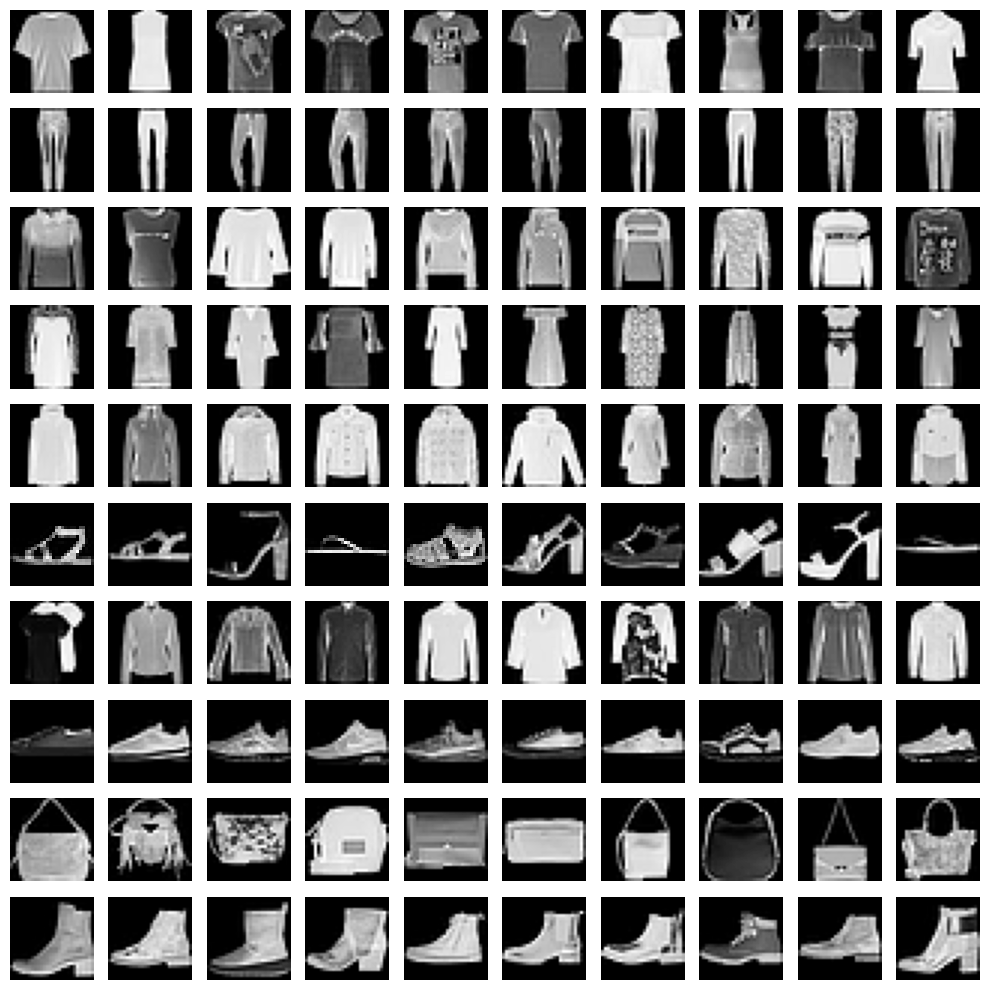

In [5]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))



for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()


In [6]:
#Class for fetching a dataset

class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x=x.float()/255
        x=x.view(-1,28*28)
        self.x, self.y = x,y
    def __getitem__(self,ix):
        x,y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [7]:
def get_data():
    train = FMNISTDataset(tr_images,tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [8]:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000, 10)
            ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [9]:
def train_batch(x, y, model, opt, loss_fn):
    model.train() 
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    
    batch_loss.backward()
   
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [10]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [11]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [12]:
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
     

0
1
2
3
4


/var/folders/3n/fwvld1h16fncxfv2jkz9b1h80000gn/T/ipykernel_10826/1668084199.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


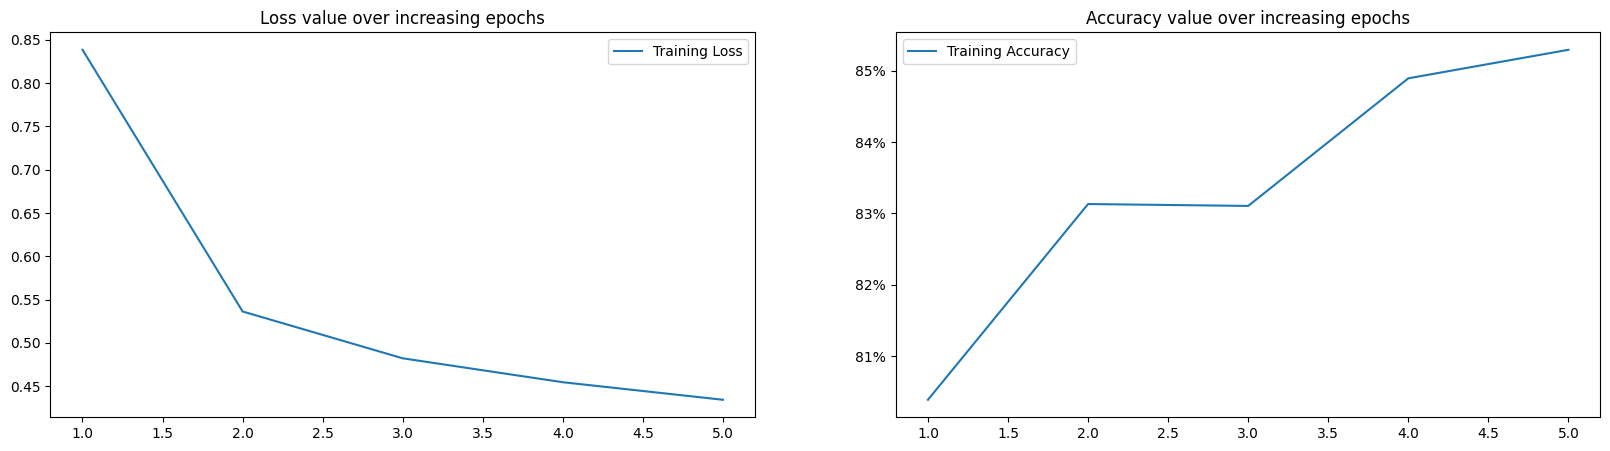

In [13]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()